# Visualization of Pytorch Model

Here is a summary of all common ways to visualize the model structure and informations using some quick and dirty tests. They use different ways to get the model information and differs in performance. I will explore them.

## create a test model
We use two models for the tests: one very simple with only 3 linear layers connected linearly and one complex constructed using the diffusion module.


In [7]:
import torch.nn as nn
import torch
model_simple = nn.Sequential(
   nn.Linear(10, 32),
    nn.Linear(32, 64),
    nn.Linear(64, 10)
)

In [3]:
from diffusers import UNet2DModel
model_complex = UNet2DModel(
    sample_size=64,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=1,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
).to('cpu')

/home/niuniu/.local/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Using python methods
By simply using python native methodes:
 * If the class has \_\_str\_\_ or \_\_repr\_\_, print fucntion or repr function can be used to show their components.
 * using mappingproxy \_\_dict\_\_, all attributes of the class can be shown including the ones from the base class.

We can also show attributes of the model (eg. model.conv_in).

In [47]:
print(model_simple)

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): Linear(in_features=32, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=10, bias=True)
)


In [5]:
print(model_complex)

UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
    

### Notes
This only show all the layers initialized, but not their connections or how the data went through the model.
No parameters or connection information were provided either.

## Torchviz
https://github.com/szagoruyko/pytorchviz

Light weight, intuitive to use.

It is constructed by backpropagating the model. It is very dangerous to test on big model and on cpu.


In [17]:
# install
!python -m pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


In [10]:
from torchviz import make_dot

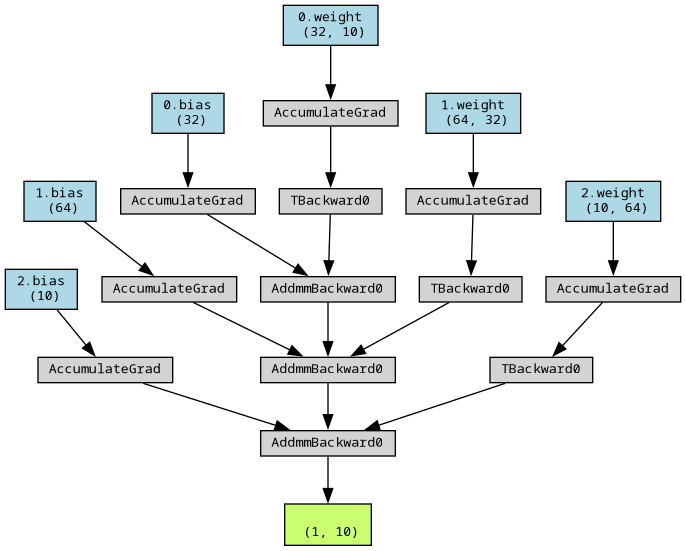

In [17]:
# simple
xs = torch.rand((1, 10))
predict = model_simple(xs)
make_dot(predict, params=dict(list(model_simple.named_parameters()))).render("lin_torchviz", format="png")

# display graph
from IPython.display import Image
Image("lin_torchviz.png")

In [12]:
#complex
x = torch.rand((1, 1, 64, 64))
t = torch.randint(0, 100, (1,))
predict = model_complex(x, t)
make_dot(predict, params=dict(list(model_complex.named_parameters()))).render("unet_torchviz", format="png")

TypeError: unhashable type: 'UNet2DOutput'

### note
The graph seems complexe to understand, expecially when the model is complex.
And not working for Unet.

## HiddenLayer
https://github.com/waleedka/hiddenlayer

It depends on onnx, which gives wiered errors. It seems it is not updated to the latest version of onnx, so not working for either models. Of course, you can dig into the repo to find the matching versions, but I don't have time for this.

In [31]:
# install
! python -m pip install hiddenlayer

Defaulting to user installation because normal site-packages is not writeable


In [14]:
import hiddenlayer as hl

In [18]:
# simple
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
graph = hl.build_graph(model_simple, (xs), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('lin_hiddenlayer', format='png')

AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'

In [20]:
# complex
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
graph = hl.build_graph(model_complex, (x,t), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('unet_hiddenlayer', format='png')

/home/niuniu/.local/lib/python3.11/site-packages/diffusers/models/resnet.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
/home/niuniu/.local/lib/python3.11/site-packages/diffusers/models/resnet.py:226: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
/home/niuniu/.local/lib/python3.11/site-packages/diffusers/models/resnet.py:139: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Py

AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'

## onnx + netron
https://github.com/lutzroeder/netron

It required another package for the visualization.

In [42]:
!python -m pip install netron
!python -m pip install onnx

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.4 MB/s eta 0:00:000:00:01m eta 0:00:01


In [21]:
# simple
input_names = ['Sentence']
output_names = ['yhat']
torch.onnx.export(model_simple, (xs), 'lin.onnx', input_names=input_names, output_names=output_names)

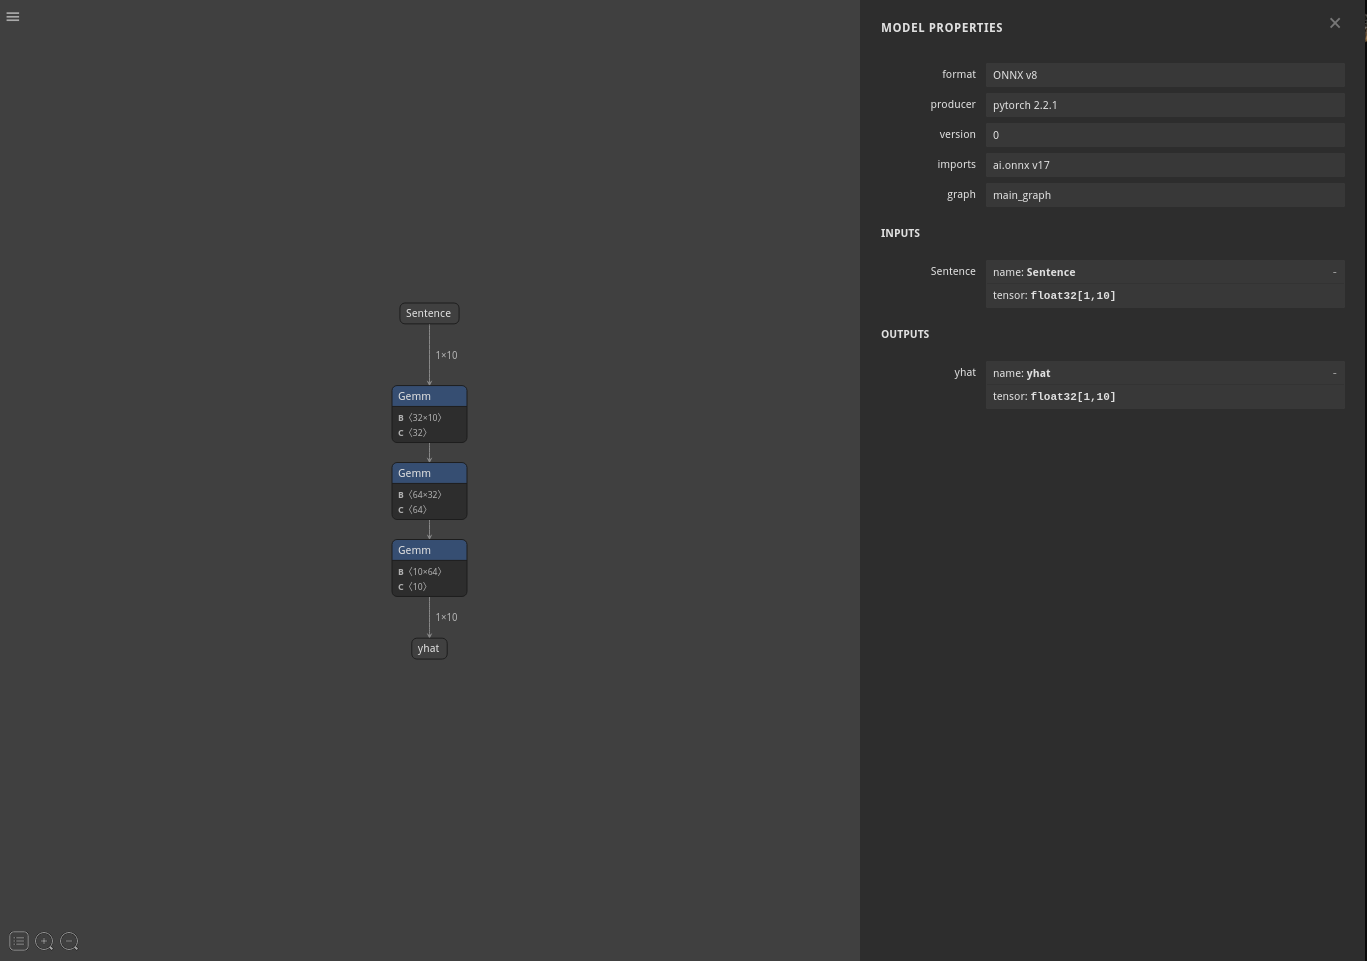

In [43]:
# display graph
# using netron to visualize the graph geenrated abve
from IPython.display import Image
Image("lin.png")

In [23]:
input_names = ['Sentence']
output_names = ['yhat']
torch.onnx.export(model_complex, (x,t), 'unet.onnx', input_names=input_names, output_names=output_names)

/home/niuniu/.local/lib/python3.11/site-packages/diffusers/models/unet_2d.py:331: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not return_dict:


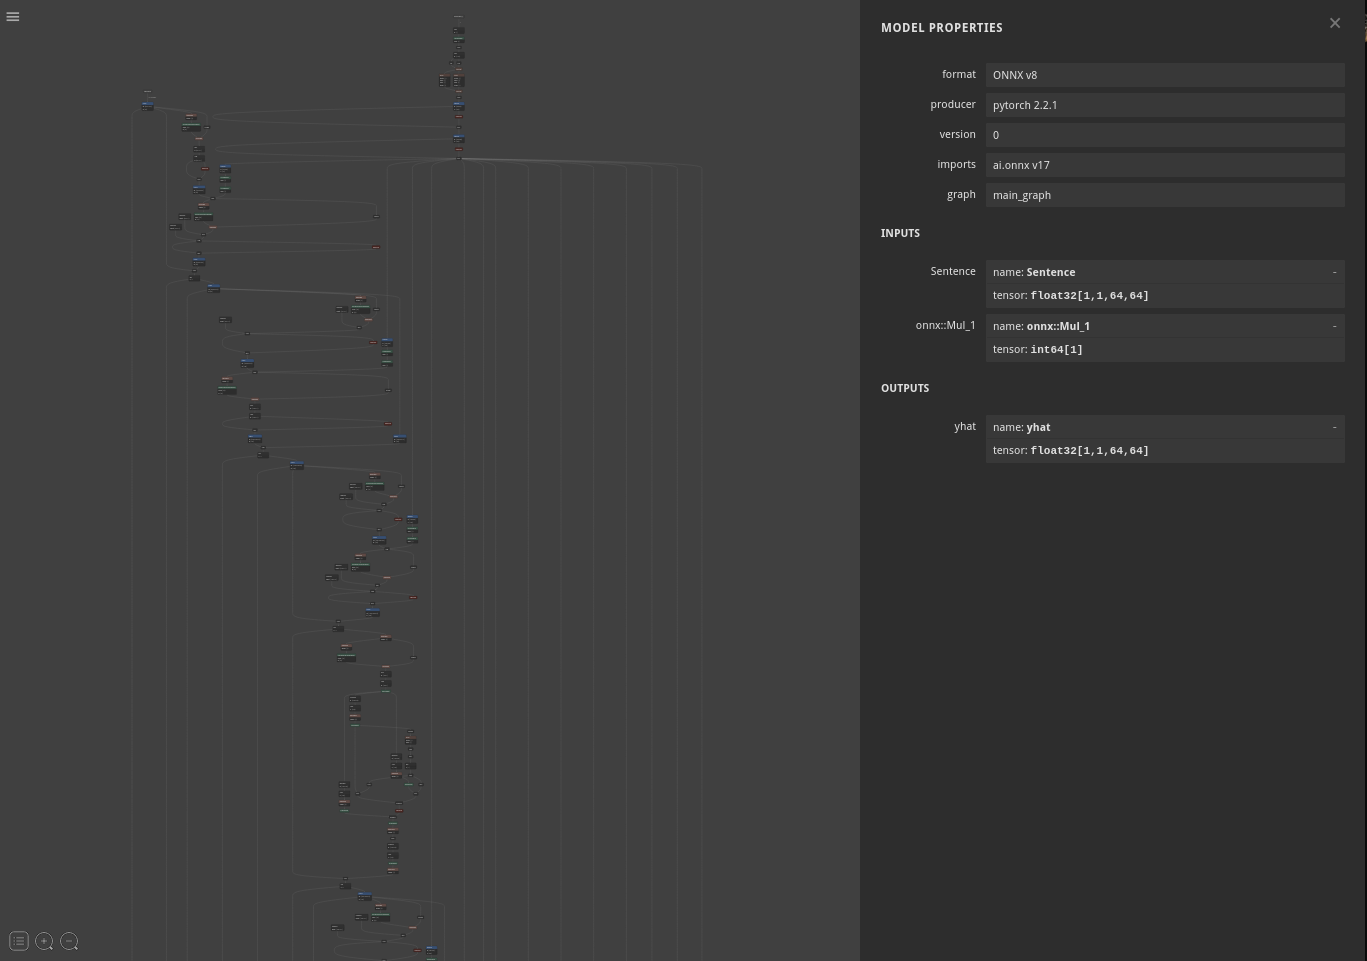

In [44]:
# display graph
# using netron to visualize the graph geenrated abve
from IPython.display import Image
Image("unet.png")

## Torchview

Light weight and fast. But when the model is complex, the graph becomes huge and hard to grasp.

In [16]:
# install
!python -m pip install torchview

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torchvision
from torchview import draw_graph

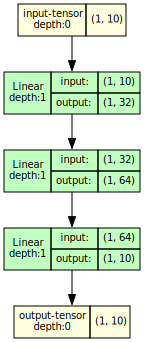

In [24]:
#simple
model_graph = draw_graph(model_simple, input_size=(1,10), expand_nested=True)
model_graph.visual_graph

/home/niuniu/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/niuniu/.local/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


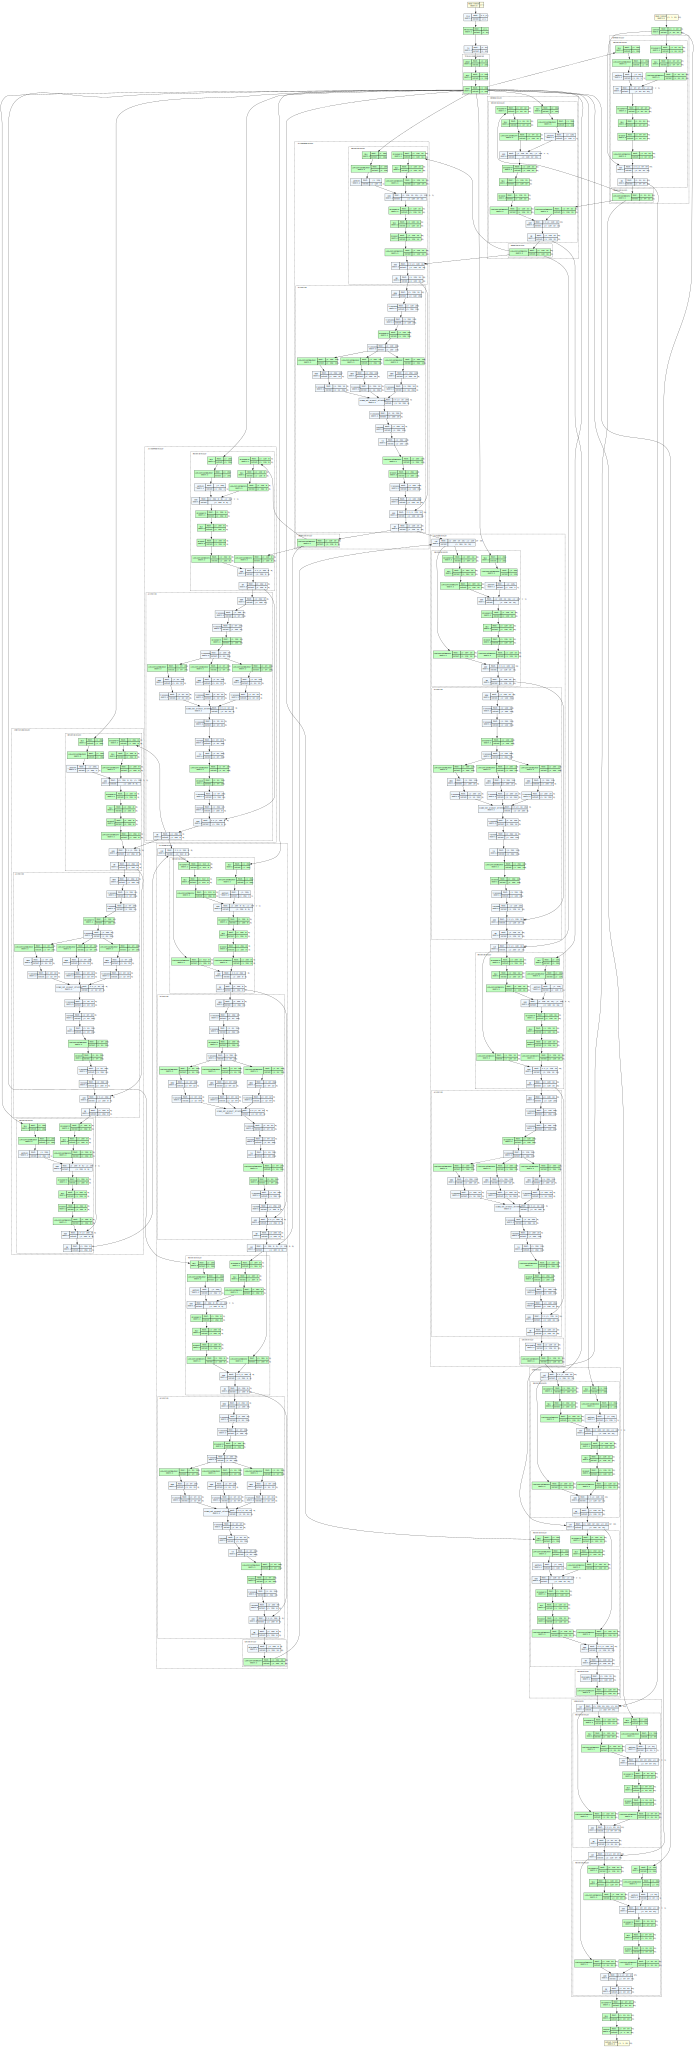

In [7]:
model_graph = draw_graph(model_complex, input_size=[(1,1,64,64), (1,)], expand_nested=True)
model_graph.visual_graph

## Torchsummary

It give a minimal display with all essential information. 

In [25]:
from torchsummary import summary

In [26]:
#simple
summary(model_simple, (1, 10), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]             352
            Linear-2                [-1, 1, 64]           2,112
            Linear-3                [-1, 1, 10]             650
Total params: 3,114
Trainable params: 3,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [27]:
# complex
summary(model_complex, [(1, 64, 64), (1,)], batch_size=-1 )

AssertionError: Timesteps should be a 1d-array

### note
For the unet I keep getting this wired error for the summary. I have no idea why.

## Torchstat
https://github.com/Swall0w/torchstat
simply not working.

In [87]:
# install
!python -m pip install torchstat

Defaulting to user installation because normal site-packages is not writeable


In [29]:
from torchstat import stat

In [49]:
# simple
stat(model_simple, (10))

AssertionError: 

In [32]:
stat(model_complex, [(1, 64, 64), (1,)])

AssertionError: 

## Torchinfo

Similar to torchsummary.

In [33]:
import torchinfo

In [34]:
# simple
torchinfo.summary(model_simple, (1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Linear: 1-1                            [1, 32]                   352
├─Linear: 1-2                            [1, 64]                   2,112
├─Linear: 1-3                            [1, 10]                   650
Total params: 3,114
Trainable params: 3,114
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [36]:
import torchinfo
torchinfo.summary(model_complex, [(1, 64, 64), (1,)])

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Timesteps: 1, TimestepEmbedding: 1, Linear: 2, SiLU: 2, Linear: 2, Conv2d: 1, ResnetBlock2D: 4, GroupNorm: 5, SiLU: 5, LoRACompatibleConv: 5, SiLU: 5, LoRACompatibleLinear: 5, GroupNorm: 5, SiLU: 5, Dropout: 5, LoRACompatibleConv: 5, Downsample2D: 4, LoRACompatibleConv: 5]